In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ast
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
%matplotlib inline

# Section I: Business Understanding
Making your home available on Airbnb can be an intimidating prospect, particularly if you live in a large, hip city where you’re forced to compete against thousands of other listings. Such is the case in Austin, TX — a city consistently ranked among the top in the US and among the fastest growing, a city that is swiftly changing to accommodate the influx of technology, a city where *keeping it weird* is and will always be a higher calling, a city that is my hometown. Though I no longer live in Austin, when I came across the Airbnb data for the city, I was intrigued to take a deeper dive in. 

The primary question I’m setting out to answer:  
**Which factors provide a home with a competitive edge?**

To answer this, we need to choose the metric that defines the measure of a competitive/successful host. I chose to use Superhost status as the measure since it encompasses a number of important metrics such as customer reviews, number of reservations, and cancellation rate. We will build a model to see how well we can predict Superhost status and dive in to the most important predictive features.  

Additionally, I want to answer some secondary questions related to basic exploratory analysis:  
**Q1: How many total listings and hosts are there? How many hosts have multiple listings?**  
**Q2: What is the breakdown of listings by type (e.g., entire home, private room, shared room, etc.)?**  
**Q3: How available are the listings?**  
**Q4: What is the average listing price and how does it compare across various neighborhoods?**

# Section II: Data Understanding

In [2]:
# List of stopwords (e.g., 'the', 'a', 'or', etc.)
stopword = stopwords.words('english')

## Import Data

In [3]:
austin_calendar = pd.read_csv('Data/Austin/calendar.csv')
austin_listings = pd.read_csv('Data/Austin/listings.csv')
austin_reviews = pd.read_csv('Data/Austin/reviews.csv')

In [4]:
austin_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,326172,2020-11-07,f,$95.00,$95.00,29.0,1125.0
1,329306,2020-11-07,f,$75.00,$75.00,2.0,1125.0
2,329306,2020-11-08,f,$75.00,$75.00,2.0,1125.0
3,329306,2020-11-09,f,$75.00,$75.00,2.0,1125.0
4,329306,2020-11-10,f,$75.00,$75.00,2.0,1125.0


In [5]:
austin_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20201107131938,2020-11-07,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,...,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20201107131938,2020-11-07,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,...,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20201107131938,2020-11-07,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,...,10.0,10.0,10.0,NaN,f,1,1,0,0,3.78
3,5636,https://www.airbnb.com/rooms/5636,20201107131938,2020-11-07,"Soco, Barton Springs Private Guest Cottage",MONTHLY Short Term <br />Located in the awesom...,This area is one of the top areas in Austin to...,https://a0.muscache.com/pictures/17705/ef0b703...,7148,https://www.airbnb.com/users/show/7148,...,10.0,10.0,9.0,NaN,t,2,2,0,0,0.14
4,5769,https://www.airbnb.com/rooms/5769,20201107131938,2020-11-07,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,...,10.0,10.0,10.0,NaN,f,1,0,1,0,2.00


In [6]:
austin_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2265,963,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,1057,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,200418,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,1001630,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,1016390,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...


## Clean Data

#### Calendar data

In [7]:
# Convert price/adjusted_price to numeric columns
austin_calendar.price = austin_calendar.price.str.replace('$','')
austin_calendar.adjusted_price = austin_calendar.adjusted_price.str.replace('$','')
austin_calendar.price = pd.to_numeric(austin_calendar.price.str.replace(',',''))
austin_calendar.adjusted_price = pd.to_numeric(austin_calendar.adjusted_price.str.replace(',',''))

# replace t and f with True and False
austin_calendar.replace('t', True, inplace=True)
austin_calendar.replace('f', False, inplace=True)

#### Listing data

In [8]:
# remove columns with all NA
austin_listings = austin_listings.dropna(axis=1, how='all')

# drop columns with zero variability
nunique = austin_listings.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
austin_listings = austin_listings.drop(cols_to_drop, axis=1)

# convert price to numeric
austin_listings.price = austin_listings.price.str.replace('$','')
austin_listings.price = pd.to_numeric(austin_listings.price.str.replace(',',''))

# convert rates to numeric
austin_listings.host_response_rate = pd.to_numeric(austin_listings.host_response_rate.str.replace('%',''))/100
austin_listings.host_acceptance_rate = pd.to_numeric(austin_listings.host_acceptance_rate.str.replace('%',''))/100

# convert id and zipcode columns to categorical columns
austin_listings.id = austin_listings.id.astype('object')
austin_listings.host_id = austin_listings.host_id.astype('object')
austin_listings.neighbourhood_cleansed = austin_listings.neighbourhood_cleansed.astype('object')
austin_listings.rename(columns={'neighbourhood_cleansed':'zipcode'}, inplace=True)

# create new zipcode column
zips_to_replace = austin_listings.zipcode.value_counts().index[austin_listings.zipcode.value_counts() < 100].tolist()
austin_listings['zipcode2'] = austin_listings.zipcode.replace(to_replace=zips_to_replace, value='Other')

# remove url & last scraped columns
url_cols = austin_listings.filter(regex='url|last_scraped').columns
austin_listings = austin_listings.drop(url_cols, axis=1)

# replace t and f with True and False
austin_listings.replace('t', True, inplace=True)
austin_listings.replace('f', False, inplace=True)

# rename columns
austin_listings.rename(columns={'id':'listing_id'}, inplace=True)

## Feature Engineering

Before jumping into model building, I performed feature engineering to create the following predictors:
1. **description_length** - This is simply the number of words the host used to describe the listing. I used to Python's NLTK library to process the data.
2. **neighborhood_overview_length** - Same as above, except it's the number of words used to describe the listing's neighborhood.
3. **amenities_length** - Number of amenities listed
4. **dist_from_downtown** - I used the latitude and longitude data provided to calculate the distance the listing is from downtown Austin in miles.
5. **available_perc** - Calculated this from a column that is True if the listing is available and False otherwise.
6. **Multi_listing** - Created a True/False column if the host had more than one listing
7. **host_yrs** - I created this from the host_since column, which lists the date a host became a host
8. **host_yrs_cat** - Categorical/binned version of host_yrs
9. **bathrooms_cat** - Categorical/binned version of bathrooms

#### Convert latitude/longitude into distance metric

In [9]:
# Define downtown Austin latitude and longitude point
austin_listings['downtown_latitude'] = 30.2729
austin_listings['downtown_longitude'] = -97.7444

In [10]:
# function to convert distance between two latitude/longitude points into miles
def lat_long_to_miles(lat1, long1, lat2, long2):
    """Return distance in miles between two points, given latitude/longitude."""
    lat1 = lat1/(180/np.pi)
    long1 = long1/(180/np.pi)
    lat2 = lat2/(180/np.pi)
    long2 = long2/(180/np.pi)
    d = 3963.0 * np.arccos((np.sin(lat1) * np.sin(lat2)) + np.cos(lat1) * np.cos(lat2) * np.cos(long2 - long1))
    return d

# vectorize so I can apply to columns in DataFrame
lat_long_to_miles = np.vectorize(lat_long_to_miles)

In [11]:
# add distance from each listing to downtown
austin_listings['dist_from_downtown'] = lat_long_to_miles(austin_listings.latitude, austin_listings.longitude, 
                                                          austin_listings.downtown_latitude, austin_listings.downtown_longitude)

In [12]:
# remove latitude/longitude columns from DataFrame
lat_long_cols = austin_listings.filter(regex='latitude|longitude').columns
austin_listings = austin_listings.drop(lat_long_cols, axis=1)

#### Years as host

In [13]:
# create numeric column listing number of years as host
austin_listings['today'] = datetime.today()
austin_listings['host_since'] = pd.to_datetime(austin_listings.host_since)
austin_listings['host_yrs'] = (austin_listings.today-austin_listings.host_since)
austin_listings['host_yrs'] = austin_listings['host_yrs'].apply(lambda x: x.days)/365

# create categorical version via binning
austin_listings['host_yrs_cat'] = pd.cut(austin_listings.host_yrs, bins=[0,3,5,7,9,11,13])

#### Host Multi-listing

In [14]:
# create bool columns denoting if a host has more than 1 or more than 2 listings
austin_listings['Multi_listing'] = [True if x > 1 else False for x in austin_listings.calculated_host_listings_count]
austin_listings['More_than_2_listings'] = [True if x > 2 else False for x in austin_listings.calculated_host_listings_count]

#### Number of words in listing description, neighborhood description, and number of amenities

In [15]:
# define function to process text
def process_text(text, stopword):
    """Return list of tokenized words with stopwords removed."""
    text = word_tokenize(str(text).lower())
    text = [word for word in text if word not in stopword and word.isalpha()]
    return text

In [16]:
# count number of words in listing/neighborhood description and number of amenities listed
austin_listings['description_length'] = austin_listings.description.apply(process_text, stopword = stopword).apply(list).apply(len)
austin_listings['neighborhood_overview_length'] = austin_listings.neighborhood_overview.apply(process_text, stopword = stopword).apply(list).apply(len)
austin_listings['amenities_length'] = austin_listings.amenities.apply(ast.literal_eval).apply(len)

#### Listing Availability

In [17]:
# join calendar and listing data
austin_cal_list = austin_calendar.merge(austin_listings, how='inner', on='listing_id')

In [18]:
# add available_perc to austin_listings data
availability_perc = austin_cal_list.groupby('listing_id')['available'].mean().reset_index().rename(columns={'available':'available_perc'})
austin_cal_list = austin_cal_list.merge(availability_perc, on = 'listing_id')
austin_listings = austin_listings.merge(availability_perc, on = 'listing_id')

#### Bathrooms

In [19]:
# clean up bathroom data - fill NA with 'missing'
austin_listings.bathrooms_text = austin_listings.bathrooms_text.fillna('missing')

# remove text (e.g. 'shared baths', 'bath', 'private')
austin_listings['bathrooms'] = austin_listings.bathrooms_text.replace(regex=' shared baths| shared bath| baths| bath| private', value='')
austin_listings.bathrooms = austin_listings.bathrooms.replace(regex='Half-bath|Private half-bath', value='.5')

# replace 'missing' with -1 to make numeric
austin_listings.bathrooms = austin_listings.bathrooms.replace(regex='missing', value='-1').astype('float')

# create binning for bathrooms
austin_listings['bathrooms_cat'] = pd.cut(austin_listings.bathrooms, bins = [0,2,4,20], include_lowest=True).astype(str)
austin_listings.bathrooms_cat = austin_listings.bathrooms_cat.replace('(-0.001, 2.0]', '0-2').replace('(2.0, 4.0]', '2-4').replace('(4.0, 20.0]', '> 4')

## Lay of the Land

Below, I look at some basic summaries of the data. I wanted to get an idea of the following metrics:
1. Total number of listings, hosts, and hosts with multiple listings
2. Breakdown of listings by type
3. Listing availability: what % of days out of the year is a listing available?
4. Distribution of listing price by neighborhood (ZIP code)

#### Breakdown of listings, hosts, and hosts with multiple listings

The table and figure below shows the total number of listings, total number of hosts, number of hosts with more than 1 listing, and number of hosts with more than two listings. Roughly 16% of hosts have more than 1 listing and 6% have more than 2 listings. The percentage of hosts with multiple listings is more than I expected. It would be interesting to see how this number compares with other large cities, but I will leave comparisons with other cities for another day.

In [20]:
host_listings = austin_listings[['host_id','Multi_listing','More_than_2_listings']].drop_duplicates()
listing_stats = pd.Series({'Total Listings':austin_listings.shape[0], 'Number of Hosts':len(austin_listings.host_id.value_counts()),
                           'Hosts with > 1 listing':np.sum(host_listings.Multi_listing), 
                           'Hosts with > 2 listings':np.sum(host_listings.More_than_2_listings)})
listing_stats = listing_stats.reset_index().rename(columns={'index':'',0:'count'})
listing_stats.style.set_properties(**{'text-align': 'left'})

,,count
0,Total Listings,10450
1,Number of Hosts,6807
2,Hosts with > 1 listing,1120
3,Hosts with > 2 listings,438


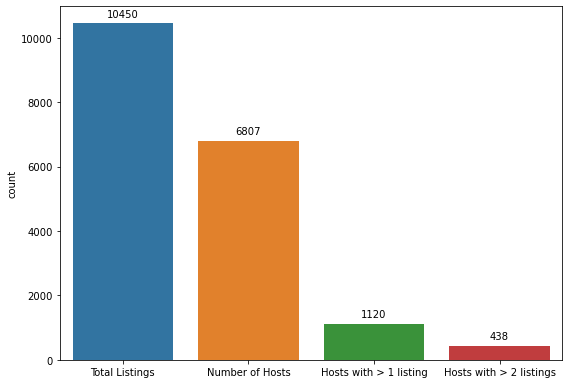

In [21]:
plt.figure(figsize=(9, 6.5))
g=sns.barplot(data=listing_stats, x='', y='count')
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')

#### Breakdown of listings by type
The table and figure below shows the breakdown of listings by type: entire home/apt, private room, shared room, or hotel room.The vast majority of listings, nearly 80%, are for the entire home or apartment, followed by 20% for private rooms. I wasn’t surprised that less than 1.5% of listings were for shared rooms and hotel rooms, especially during the Covid-19 pandemic. It would be interesting to see if this number significantly dropped from 2019.

In [22]:
room_type_percent = austin_listings.room_type.value_counts(normalize=True).reset_index().rename(columns={'index':'listing','room_type':'percentage'})
room_type_percent.percentage = room_type_percent.percentage*100
room_type_count = austin_listings.room_type.value_counts().reset_index().rename(columns={'index':'listing','room_type':'count'})
room_type_summary = room_type_count.merge(room_type_percent, on = 'listing')

In [23]:
room_type_summary.round(decimals=2)

,listing,count,percentage
0,Entire home/apt,8148,77.97
1,Private room,2159,20.66
2,Shared room,130,1.24
3,Hotel room,13,0.12


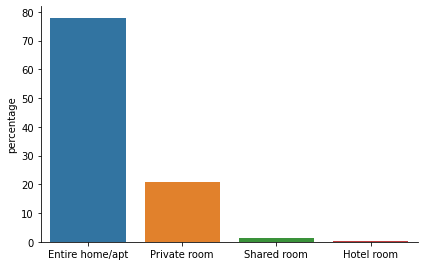

In [24]:
# listing type
g=sns.catplot(data=room_type_summary, x='listing', y='percentage', kind='bar', height = 4, aspect=1.5)
g.set_axis_labels("");

#### Listing Availability
The histogram below shows the number of listings available for various percentage of nights throughout the year. On average, listings are available for booking approximately 135 nights (37%) out of the year. Around 35% of listings have no availability over the course of the next year, either because they are already fully booked or because the host has taken it off the market. On the flip side, around 13% of listings are available over 95% of nights out of the year. This high availability suggests that the average Airbnb host in Austin most likely doesn’t live at their listing.

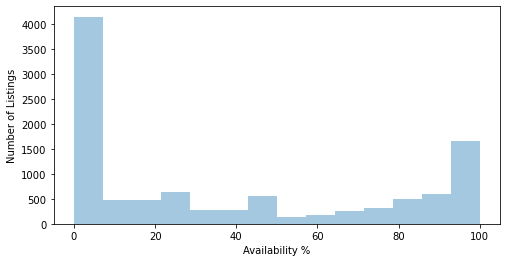

In [25]:
plt.figure(figsize=(8,4)) 
fig = sns.distplot(austin_listings.available_perc*100, kde=False)
fig.set(xlabel='Availability %', ylabel='Number of Listings');

In [26]:
average_availability = austin_listings.available_perc.mean()
no_availability = np.sum(austin_listings.available_perc == 0)/austin_listings.shape[0]
over_95perc_availability = np.sum(austin_listings.available_perc > .95)/austin_listings.shape[0]

In [27]:
average_availability

0.3746438209317951

In [28]:
no_availability

0.3526315789473684

In [29]:
over_95perc_availability

0.13330143540669856

#### Listing price by neighborhood
The boxplot below shows the price distribution for listings in each Zip Code. I plotted price on the Y-axis on the log10 scale so that the differences in distribution would be more clearly seen. The average listing price is \\$267 per night, while the median listing price is significantly lower at \\$130. This makes sense given the price distribution, where a good number of homes are listed for more \\$1K and some are \\$10K+, driving the average up. Median listing prices by ZIP code range from \\$60 in 78725, which is on the far east side of Austin near the airport, to \\$437 in 78732, which is in the hill country and near the lake — surprise!

In [30]:
avg_price_zip_summary = austin_listings.groupby('zipcode')['price'].median().reset_index().sort_values('price', ascending=False)

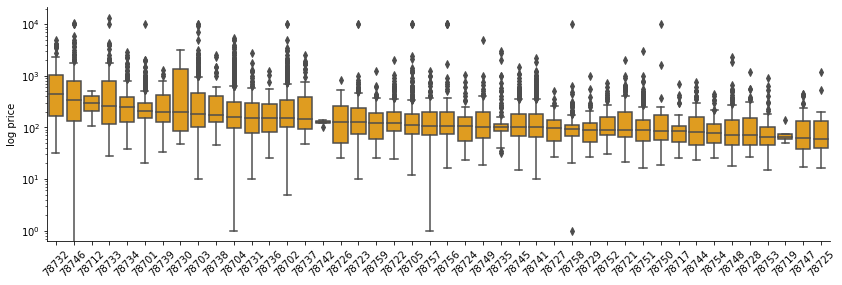

In [31]:
g = sns.catplot(data=austin_listings, x='zipcode', y='price', color='orange', kind='box', 
                order=avg_price_zip_summary.zipcode, height=4, aspect=3)
g.set_xticklabels(rotation=45)
g.set(yscale="log", xlabel='', ylabel = 'log price');

# Section III: Modeling

## Can we predict Superhost status?

As a measure for how successful a host is, Superhost status encompasses the important metrics - customer reviews, number of reservations, cancellation rate, etc. If we use all the data that is available to us, I will not pretend that achieving high prediction accuracy for whether a host is a Superhost is impressive. Why? Because the requirements are straightforward and any human with access to that information should be able to achieve 100% accuracy. So to make our problem interesting and more useful, I excluded data related to reviews from the classification algorithm.

Below is a summary of the key steps I took to get the data ready for modeling:
1. Filter out unuseful or redundant predictors, including data related to reviews
2. Drop rows with missing Superhost status
3. One-hot encode categorical predictors
4. Remove predictors with zero or low variability
5. Collapse data to include only one row for each host
6. Convert DataFrames into numpy arrays for sklearn compatibility
7. Run 5-fold CV and measure average performance
8. Impute missing values on full dataset
9. Fit final model on full dataset
10. Calculate feature importance and plot ranked predictors

#### Filter out unuseful/redundant predictors

I removed columns that clearly don't have predictive power such as 'listing_id', 'name', 'host_id', 'host_name', etc. I also removed columns with raw text since I decided not to dig too deeply into NLP here (outside of counting the number of words for listing/neighborhood descriptions). As I have already mentioned, I removed columns related to customer reviews.

The correlation heatmap below gives a quick picture of highly correlated predictors. I removed redundant predictors; for example, I only kept 'maximum_nights' and 'minimum_nights' but removed all other highly correlated variations such as 'maximum_minimum_nights'.  

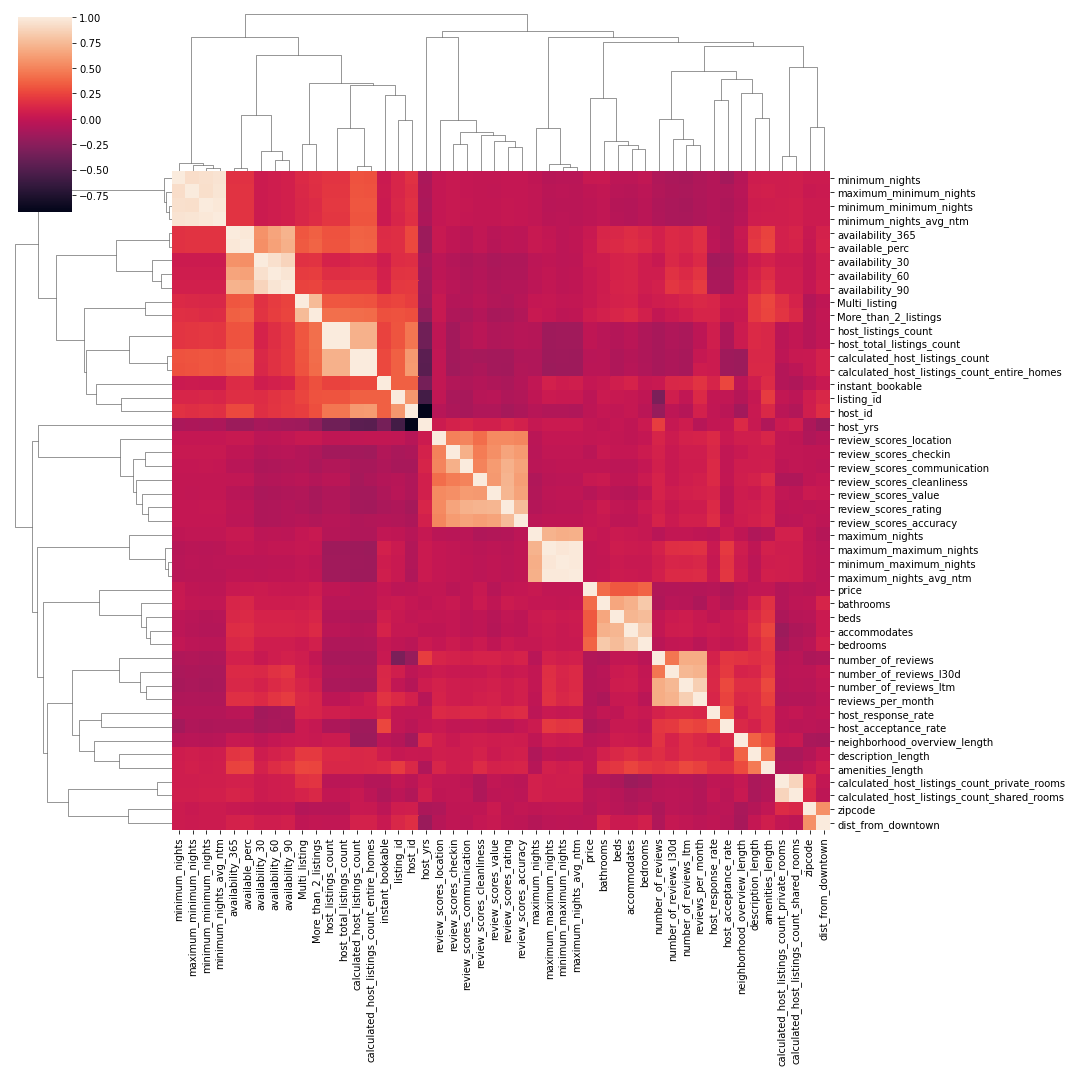

In [32]:
sns.clustermap(austin_listings.corr(), figsize = (15,15));

In [33]:
# print columns in austin_listings
austin_listings.columns

Index(['listing_id', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'zipcode', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating',

In [34]:
# predictors to include for predicting Superhost status
regex_arg = 'host|price|minimum|maximum|available|room_type|accommodates|bath|bed|calculated|dist|Multi|length'
host_cols = austin_listings.filter(regex=regex_arg).columns.tolist()

In [35]:
# predictors to exclude
host_cols_remove = ['host_name', 'host_since', 'host_location', 'host_about','host_verifications','minimum_minimum_nights',
                    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                    'maximum_nights_avg_ntm','host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
                    'bathrooms_text', 'bathrooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
                    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
                    'calculated_host_listings_count_shared_rooms']
host_cols = [x for x in host_cols if x not in host_cols_remove]

In [36]:
# filter out predictors
host_data = austin_listings.filter(host_cols)

#### Drop rows with missing Superhost status

In [37]:
# drop rows with missing values for Superhost status. If we left any missing values here, our model would throw an error. 
host_data = host_data.dropna(subset=['host_is_superhost'])

#### One-hot encode categorical predictors

In [38]:
# code categorical variables as dummy variables
host_data_dummy = pd.get_dummies(host_data, drop_first=True, dummy_na=True)

#### Drop predictors with zero/low variability

I dropped predictors with sample standard deviation less than 0.1 since these are less likely to have predictive power. 

In [39]:
# drop predictors with zero/low variability
cols_to_drop = host_data_dummy.var()[host_data_dummy.std() < .1].index.tolist()
host_data_dummy = host_data_dummy.drop(columns=cols_to_drop)

In [40]:
#convert dummy cols to bool
cols_to_bool = host_data_dummy.dtypes[host_data_dummy.dtypes == 'uint8'].index.tolist()
host_data_dummy[cols_to_bool] = host_data_dummy[cols_to_bool].astype('bool')
bool_cols = host_data_dummy.dtypes[host_data_dummy.dtypes == 'bool'].index.tolist()

#### Collapse data to include only one row for each host

For hosts with multiple listings, I grouped the data by host_id and took the mean for each predictor. I did this so that the data would consist of one row per host. 

In [41]:
# group by host_id and compute mean
host_data_dummy2 = host_data_dummy.groupby('host_id').mean().reset_index()
host_data_dummy2 = host_data_dummy2.drop(columns=['host_id'])
host_data_dummy2[bool_cols] = host_data_dummy2[bool_cols].astype('bool')

In [42]:
host_data_dummy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_response_rate                     3090 non-null   float64
 1   host_acceptance_rate                   3843 non-null   float64
 2   accommodates                           6804 non-null   float64
 3   bedrooms                               6440 non-null   float64
 4   beds                                   6762 non-null   float64
 5   price                                  6804 non-null   float64
 6   minimum_nights                         6804 non-null   float64
 7   maximum_nights                         6804 non-null   float64
 8   calculated_host_listings_count         6804 non-null   float64
 9   dist_from_downtown                     6804 non-null   float64
 10  host_yrs                               6804 non-null   float64
 11  Mult

#### Plot columns with missing values
The figure below shows the columns with missing values. Host response rate and host acceptance rate have a little over 50% and 40% of measurements missing, respectively. These are relatively high numbers but not high enough to warrant dropping completely. Bedrooms have less than 10% missing values and beds have under 5%. We will use a multivariate imputation method to impute missing values. 

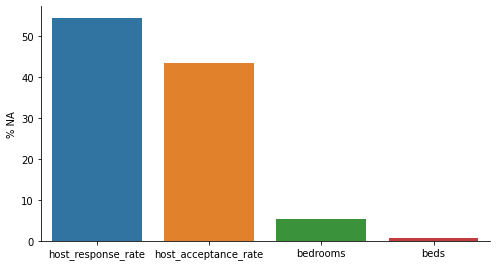

In [43]:
# Predictors with missing values
na_percent = (host_data_dummy2.isnull().sum()/host_data_dummy2.shape[0]).reset_index()
na_percent = na_percent.rename(columns={'index':'predictor',0:'percent'}).sort_values('percent', ascending=False)
na_percent['percent'] = na_percent.percent*100
g=sns.catplot(data=na_percent[na_percent.percent > 0], x='predictor', y='percent', kind='bar', height = 4, aspect=1.75)
g.set(xlabel = '', ylabel='% NA');

#### Convert data to numpy arrays for compatibility with sklearn

I split data into predictors (X) and Superhost status column (y) and converted them into numpy arrays for compatibility with sklearn. 

In [44]:
X_df = host_data_dummy2.drop(columns=['host_is_superhost_True'])

# convert DataFrames to numpy arrays
X = X_df.to_numpy()
y = host_data_dummy2['host_is_superhost_True'].to_numpy()

#### 5-fold CV - Random Forest classification
I decided to use scikit-learn's Random Forest classifier since it is not limited to a linear decision boundary and has some nice properties that combat overfitting. It also has a built in feature importance ranking, which is useful for our purposes. I used a multivariate imputation method from scikit-learn, IterativeImputer, to impute missing values. I made sure to perform the imputation using the training folds each time to protect against data leakage from the test folds. I used accuracy and AUC (area under the ROC curve) to measure performance of the model. 

In [45]:
# instantiate multivariate imputer
imp = IterativeImputer(max_iter=100, random_state=0)

In [46]:
# instantiate 5-fold CV and get splits
kf = KFold(n_splits=5)
kf.get_n_splits(X)

# create empty performance metric lists
class_report = []
auc = []
for train_index, test_index in kf.split(X):
    # split into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit multivariate imputation on training data
    imp.fit(X_train)
    
    # impute missing values on training data
    X_train = imp.transform(X_train)
    
    # impute missing values on test data using trained imputer on training data
    X_test = imp.transform(X_test)
    
    # Random Forest model
    rfor_reg = RandomForestClassifier(random_state=0).fit(X_train, y_train)
    
    # predict class
    y_pred = rfor_reg.predict(X_test)
    
    # predict class probabilities
    y_pred_probs = rfor_reg.predict_proba(X_test)[:,1]
    
    # performance metrics
    class_report.append(classification_report(y_test, y_pred, output_dict=True))
    auc.append(roc_auc_score(y_test, y_pred_probs))

# Section IV: Evaluate Results

In [47]:
# get accuracy from class_report
accuracy = [class_report[x]['accuracy'] for x in range(len(class_report))]

# average accuracy and auc over the 5 folds
mean_accuracy = np.mean(accuracy)
mean_auc = np.mean(auc)

#### Impute missing values on full dataset and fit final model

In [48]:
# fit final model on all training data
imp.fit(X)
X_new = imp.transform(X)
rfor_reg = RandomForestClassifier(max_features='sqrt',random_state=0).fit(X_new, y)

#### Calculate feature importance and plot ranked features
The figure below shows the features ranked by importance, which was computed using the built in impurity based metric in scikit-learn's Random Forest classifier. 

In [49]:
# sort and features by importance
ranked_idx = (-rfor_reg.feature_importances_).argsort()
ranked_predictors = pd.DataFrame(rfor_reg.feature_importances_[ranked_idx].reshape(1,29), columns=X_df.iloc[:,ranked_idx].columns)
ranked_predictors = ranked_predictors.transpose().reset_index().rename(columns={'index':'predictor',0:'importance'})

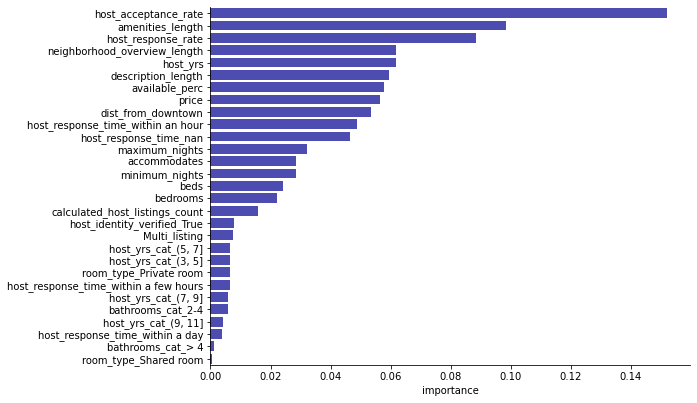

In [50]:
g=sns.catplot(data=ranked_predictors, x='importance', y='predictor', kind='bar', color='#3c3cc2', height= 5.7, aspect=1.75)
g.set(ylabel = '');

Looking at the top predictors, I think there is some valuable insight to gain a competitive edge. I will focus on things that are directly in the host's control since obviously not everything is. For example, a host can't control how large the home is or where it's located. 

Below I plot average measures for 6 of the top 8 predictors, grouped by Superhost status. 
1. Host acceptance rate
2. Number of amenities offered
3. Host response rate
4. Neighborhood description
5. Listing description
6. Listing price.

In [51]:
host_data.host_acceptance_rate = host_data.host_acceptance_rate*100
host_data.host_response_rate = host_data.host_response_rate*100

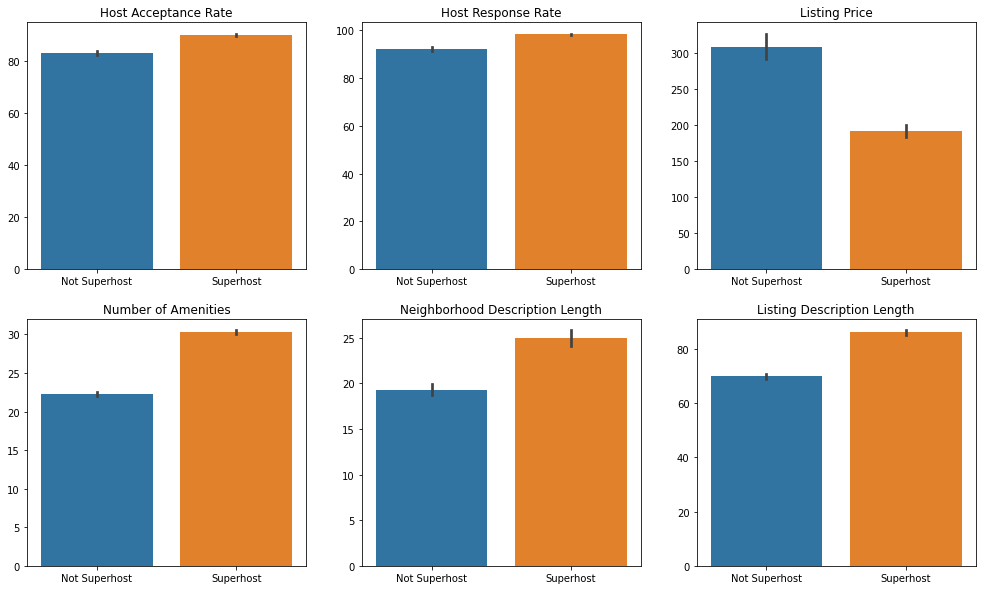

In [52]:
fig, ax = plt.subplots(2, 3, sharey=False, figsize=(17,10))
sns.barplot(data=host_data, x='host_is_superhost', y='host_acceptance_rate', ax=ax[0,0])
sns.barplot(data=host_data, x='host_is_superhost', y='host_response_rate', ax=ax[0,1])
sns.barplot(data=host_data, x='host_is_superhost', y='price', ax=ax[0,2])
sns.barplot(data=host_data, x='host_is_superhost', y='amenities_length', ax=ax[1,0])
sns.barplot(data=host_data, x='host_is_superhost', y='neighborhood_overview_length', ax=ax[1,1])
sns.barplot(data=host_data, x='host_is_superhost', y='description_length', ax=ax[1,2])
ax[0,0].set_title('Host Acceptance Rate')
ax[0,1].set_title('Host Response Rate')
ax[0,2].set_title('Listing Price')
ax[1,0].set_title('Number of Amenities')
ax[1,1].set_title('Neighborhood Description Length')
ax[1,2].set_title('Listing Description Length')
ax[0,0].set(xlabel='',ylabel='')
ax[0,1].set(xlabel='',ylabel='')
ax[0,2].set(xlabel='',ylabel='')
ax[1,0].set(xlabel='',ylabel='')
ax[1,1].set(xlabel='',ylabel='')
ax[1,2].set(xlabel='',ylabel='')
ax[1,0].set(ylabel='')
ax[1,1].set(ylabel='')
ax[1,2].set(ylabel='')
ax[0,0].set_xticklabels(['Not Superhost', 'Superhost'])
ax[0,1].set_xticklabels(['Not Superhost', 'Superhost'])
ax[0,2].set_xticklabels(['Not Superhost', 'Superhost'])
ax[1,0].set_xticklabels(['Not Superhost', 'Superhost'])
ax[1,1].set_xticklabels(['Not Superhost', 'Superhost'])
ax[1,2].set_xticklabels(['Not Superhost', 'Superhost']);